In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import torch
from scipy.stats import pearsonr

from pytorch_lightning.cli import LightningCLI

from pdearena.data.utils import PDEDataConfig
from pdearena.models.pderefiner import PDERefiner
from pdearena.data.datamodule import PDEDataModule
from pdearena.data.utils import PDEDataConfig

from pdearena.utils import PDECLI
from pdearena.models.pdemodel import PDEModel

import sys

/home/dan/Desktop/STUDY/ADL4Phys_seminar/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# data_dir = '/media/dan/DATA1/Kuramoto-Sivashinsky-Cond'
data_dir = '/media/dan/DATA1/Kuramoto-Sivashinsky-Fixed'
# checkpoint_file = os.path.abspath('saved_checkpoints/epoch_029.ckpt')
# config_file = os.path.abspath('./configs/kuramotosivashinsky1d.yaml')
checkpoint_file = os.path.abspath('outputs/ckpts/epoch_009.ckpt')
config_file = os.path.abspath('./configs/kuramotosivashinsky1d_FNO.yaml')

# Remove Jupyter-specific arguments
sys.argv = sys.argv[:1]

traj_len = 2048

arguments = ''
arguments += '-c ' + config_file
arguments += ' --data.data_dir ' + data_dir
arguments += ' --data.batch_size ' + str(traj_len)

sys.argv.extend(arguments.split(" "))

# from scripts.pderefiner_train import CondCLI
# cli = CondCLI(
#     PDERefiner,
#     PDEDataModule,
#     run=False,
#     parser_kwargs={"parser_mode": "omegaconf"},
# )

cli = PDECLI(
    PDEModel,
    datamodule_class=PDEDataModule,
    run=False,
    parser_kwargs={"parser_mode": "omegaconf"},
)

Global seed set to 42
/home/dan/Desktop/STUDY/ADL4Phys_seminar/.venv/lib/python3.8/site-packages/pytorch_lightning/cli.py:601: UserWarning: `PDEModel.configure_optimizers` will be overridden by `PDECLI.configure_optimizers`.
  _warn(
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:

checkpoint = torch.load(checkpoint_file)

In [8]:
cli.model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [9]:
cli.datamodule.setup()

Loading train data from 1 files.
Loading valid data from 1 files.
Loading valid data from 1 files.
Loading test data from 1 files.
Loading test data from 1 files.


In [10]:
train_dataloader = cli.datamodule.train_dataloader()
val_dataloader = cli.datamodule.val_dataloader()
test_dataloader = cli.datamodule.test_dataloader()

In [11]:
for batch in train_dataloader:
    inputs, targets, cond = batch
    break
# cond = cond[0:1, :]

In [12]:
inputs.shape

torch.Size([2048, 1, 1, 256])

In [16]:
file_path = '/media/dan/DATA1/Kuramoto-Sivashinsky-Fixed/KS_test_fixed_viscosity.h5'

def print_structure(name, obj):
    print(name)

with h5py.File(file_path, 'r') as f:
    f.visititems(print_structure)
    data = f['test/pde_640-256']
    npdata = np.array(data, dtype=np.float32)
    
len_traj = 140

test
test/dt
test/dx
test/pde_640-256
test/t
test/x


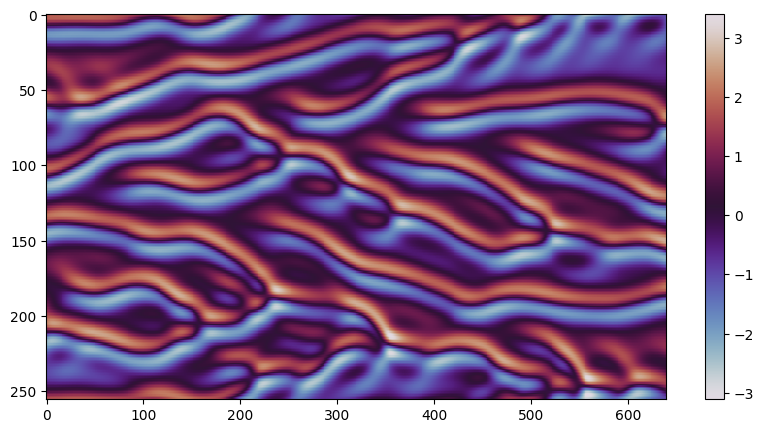

In [17]:
plt.figure(figsize=(10,5))
#set cmap
plt.set_cmap('twilight')
plt.imshow(npdata[0,:,:].T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

In [18]:
initial_condition = npdata[0:1, 0:1, :]
initial_condition = np.expand_dims(initial_condition, axis=0)
initial_condition = torch.tensor(initial_condition, dtype=torch.float32)

In [20]:
prediction_traj = []


cli.model.eval()
with torch.no_grad():
    u = initial_condition
    for i in range(len_traj):
        # prediction = cli.model(u, None)
        prediction = cli.model(u)
        prediction_traj.append(prediction[0].numpy())
        u = prediction
        
prediction_traj = np.array(prediction_traj)

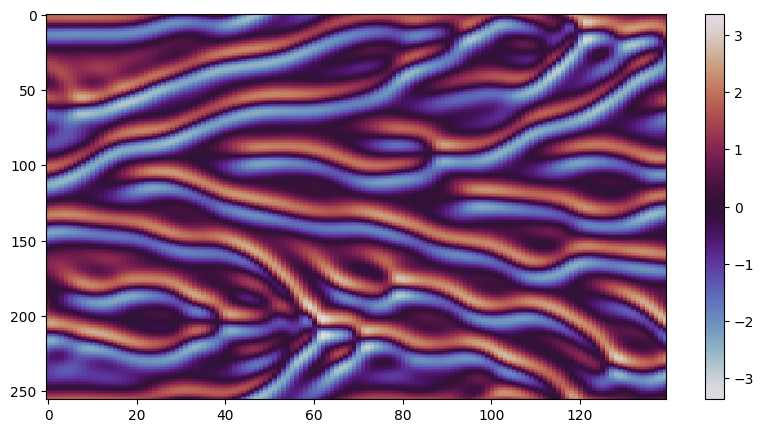

In [21]:
plt.figure(figsize=(10,5))
#set cmap
plt.set_cmap('twilight')
plt.imshow(prediction_traj[:,0, 0,:].T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

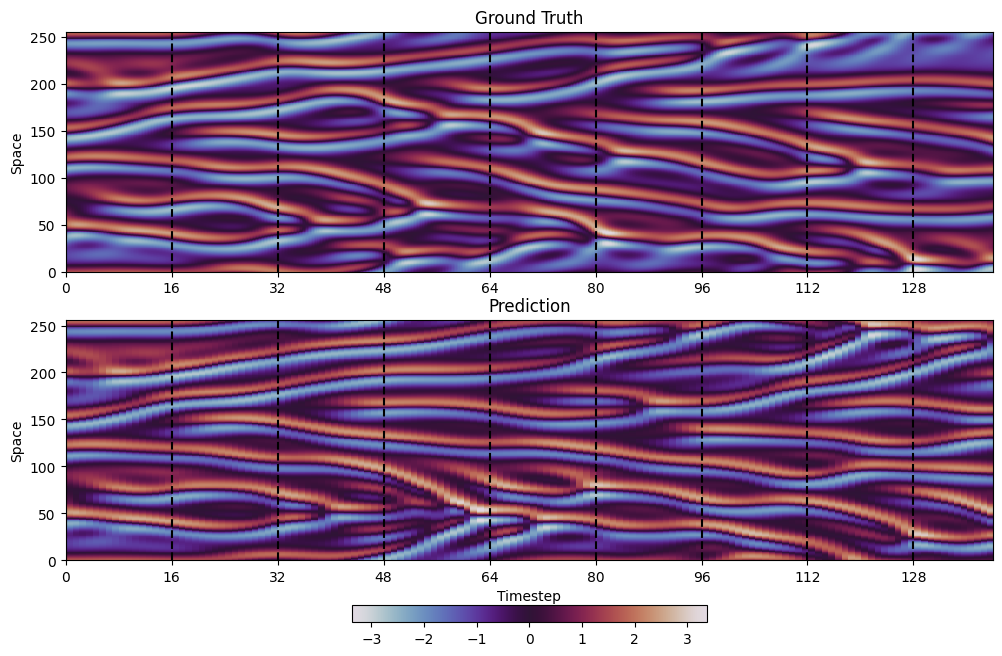

In [22]:
#plot one above the other
fig, axs = plt.subplots(2, 1, figsize=(10,6.5))

xticks = np.arange(0, 1, 160/140/10)*140

n_last=30

#set cmap
plt.set_cmap('twilight')
plt.tight_layout()
im1 = axs[0].imshow(npdata[0,:-n_last,:].T, aspect='auto', interpolation='none',extent=[0, 140, 0, prediction_traj.shape[3]])
axs[0].set_title('Ground Truth')
axs[0].set_ylabel('Space')
axs[0].set_xticks(xticks)

im2 = axs[1].imshow(prediction_traj[:,0, 0,:].T, aspect='auto', interpolation='none',extent=[0, 140, 0, prediction_traj.shape[3]])
axs[1].set_title('Prediction')
axs[1].set_ylabel('Space')
axs[1].set_xlabel('Timestep')
axs[1].set_xticks(xticks)
#vertical line at 200
for ax in axs:
    for x in xticks:
        ax.axvline(x=x, color='k', linestyle='--')

#remove margins
plt.subplots_adjust(wspace=0, hspace=0.2)

fig.colorbar(im2, ax=axs, orientation='horizontal', fraction=0.03, pad=0.075)
plt.savefig('ks_prediction.pdf')
plt.show()

In [23]:
npdata.shape
# batch, time, space

samples = 16
timesteps = 100

fft_data = []
#get fft of one spacial slice at a time
for s in range(samples):
    for t in range(timesteps):
        fft_data.append(np.fft.fft(npdata[s, t, :]))
        
fft_data = np.array(fft_data)
fft_data = np.abs(fft_data)
fft_data = np.mean(fft_data, axis=0)

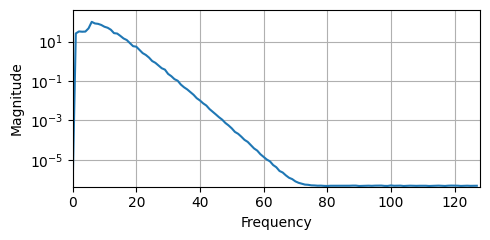

In [24]:
fft_data.shape
plt.figure(figsize=(5,2.5))
plt.plot(np.abs(fft_data[:len(fft_data)//2]))
#log y axis
plt.yscale('log')
plt.xlim(0, 256/2)
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.ylim(np.min(fft_data), np.max(fft_data)*4)
plt.tight_layout()
plt.margins(0)
plt.savefig('ks_fft.pdf')
plt.show()

In [26]:
prediction = prediction_traj[:,0, 0,:]
ground_truth = np.zeros_like(prediction)
for i in range(len_traj):
    index = int((640-n_last)/len_traj*i)
    ground_truth[i] = npdata[0, index, :]
    
len_traj, space_dim = ground_truth.shape

# Calculate Pearson correlation for each timestep
correlations = np.zeros(len_traj)
for i in range(len_traj):
    correlations[i], _ = pearsonr(ground_truth[i], prediction[i])

integral_value = np.trapz(correlations) / len_traj
print(f'Integral value: {integral_value}')

Integral value: 0.26689328405689344


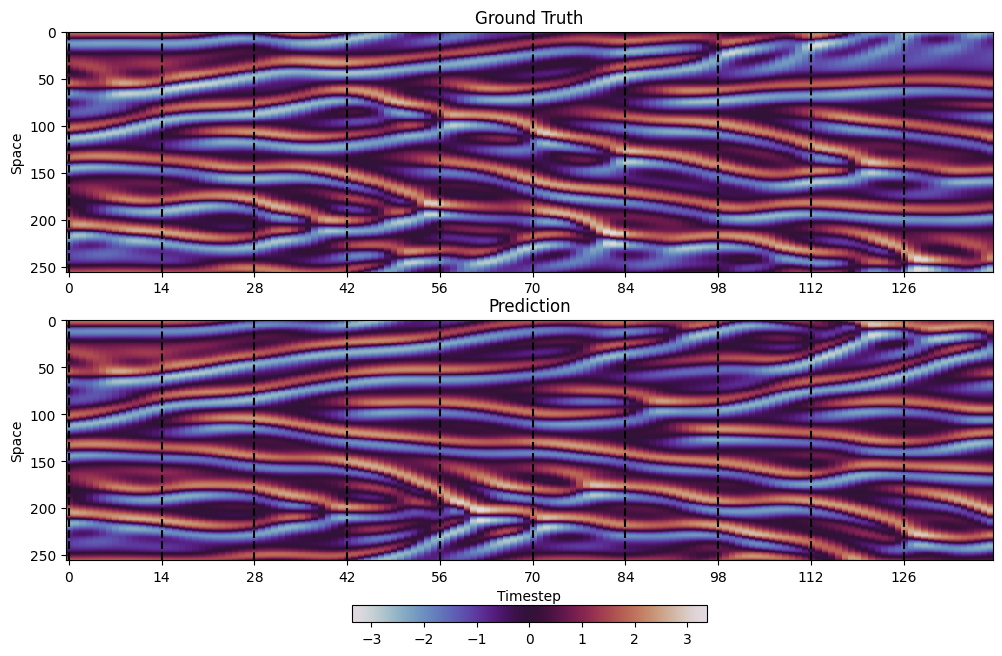

In [27]:
#plot one above the other
fig, axs = plt.subplots(2, 1, figsize=(10,6.5))

xticks = np.arange(0, 1, 0.1)*len_traj

#set cmap
plt.set_cmap('twilight')
plt.tight_layout()
im1 = axs[0].imshow(ground_truth.T, aspect='auto', interpolation='none')
axs[0].set_title('Ground Truth')
axs[0].set_ylabel('Space')
axs[0].set_xticks(xticks)

im2 = axs[1].imshow(prediction.T, aspect='auto', interpolation='none')
axs[1].set_title('Prediction')
axs[1].set_ylabel('Space')
axs[1].set_xlabel('Timestep')
axs[1].set_xticks(xticks)
#vertical line at 200
for ax in axs:
    for x in xticks:
        ax.axvline(x=x, color='k', linestyle='--')

#remove margins
plt.subplots_adjust(wspace=0, hspace=0.2)

fig.colorbar(im2, ax=axs, orientation='horizontal', fraction=0.03, pad=0.075)
plt.savefig('ks_prediction.pdf')
plt.show()

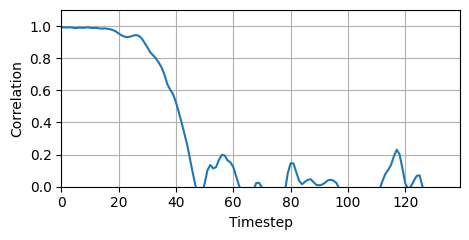

In [28]:
# Plot the Pearson correlation over time
plt.figure(figsize=(5,2.5))
plt.plot(correlations, label='Pearson Correlation')
plt.xlabel('Timestep')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.margins(0)
plt.ylim(0, 1.1)
plt.savefig('pearson_correlation.pdf')
plt.show()

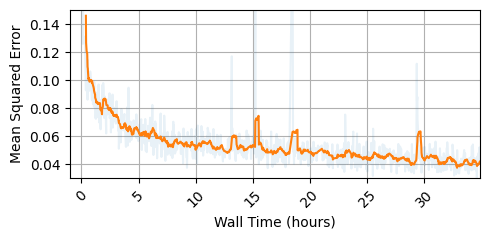

In [387]:
import pandas as pd

file_path = 'version_4.csv'

data = pd.read_csv(file_path)

# Convert "Wall time" from seconds to hours
data['Wall time hours'] = (data['Wall time'] - data['Wall time'].iloc[0]) / 3600

# Plot the data
plt.figure(figsize=(5,2.5))
plt.plot(data['Wall time hours'], data['Value'], linestyle='-', alpha=0.1)
plt.plot(data['Wall time hours'], data['Value'].rolling(window=11).mean())
plt.xlabel('Wall Time (hours)')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0.03, 0.15)
plt.xlim(-1, max(data['Wall time hours']))
plt.margins(0)
plt.grid(True)
plt.savefig('train.pdf')
plt.show()